In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
print("Loading data...")
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

Loading data...


In [3]:
# Data preparation
print("\nPreparing data...")
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=['number']).columns

# Fill missing values
for col in categorical_features:
    df[col] = df[col].fillna('NA')
for col in numerical_features:
    if col != 'converted':
        df[col] = df[col].fillna(0.0)

# Split data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"Data split - Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")


Preparing data...
Data split - Train: 876, Val: 293, Test: 293


In [4]:
print("\n=== Question 1 ===")
target = 'converted'
numerical_vars = ['lead_score', 'interaction_count', 'number_of_courses_viewed', 'annual_income']

print("Calculating AUC for numerical variables...")
auc_scores = {}
for var in numerical_vars:
    auc = roc_auc_score(df_train[target], df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(df_train[target], -df_train[var])
    auc_scores[var] = auc
    print(f"{var}: {auc:.4f}")

best_var = max(auc_scores, key=auc_scores.get)
print(f"\nNumerical variable with highest AUC: {best_var}")
print(f"ANSWER 1: {best_var}")


=== Question 1 ===
Calculating AUC for numerical variables...
lead_score: 0.6145
interaction_count: 0.7383
number_of_courses_viewed: 0.7636
annual_income: 0.5520

Numerical variable with highest AUC: number_of_courses_viewed
ANSWER 1: number_of_courses_viewed


In [5]:
print("\n=== Question 2 ===")
y_train = df_train[target].values
y_val = df_val[target].values

train_dict = df_train.drop(columns=[target]).to_dict(orient='records')
val_dict = df_val.drop(columns=[target]).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc_val:.3f}")

# Determine which option is closest
options = [0.32, 0.52, 0.72, 0.92]
closest_option = min(options, key=lambda x: abs(x - auc_val))
print(f"ANSWER 2: {closest_option}")


=== Question 2 ===
Validation AUC: 0.817
ANSWER 2: 0.72



=== Question 3 ===
Precision and recall intersect at threshold: 0.980
At intersection - Precision: 0.000, Recall: 0.000


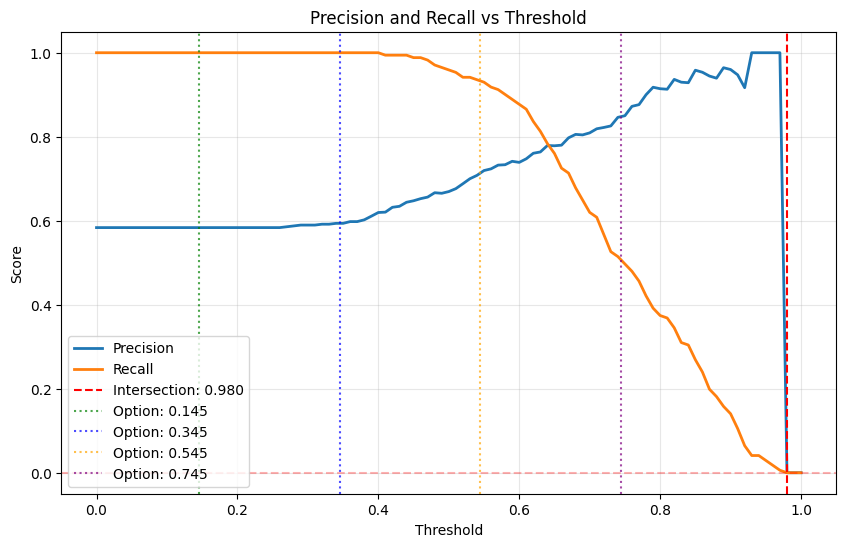

ANSWER 3: 0.745

Values around intersection (threshold 0.980):
Threshold 0.960: Precision=1.000, Recall=0.018, Diff=0.982
Threshold 0.970: Precision=1.000, Recall=0.006, Diff=0.994
Threshold 0.980: Precision=0.000, Recall=0.000, Diff=0.000
Threshold 0.990: Precision=0.000, Recall=0.000, Diff=0.000
Threshold 1.000: Precision=0.000, Recall=0.000, Diff=0.000


In [6]:
print("\n=== Question 3 ===")
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

intersection_threshold = None
min_diff = float('inf')
intersection_idx = None

for i, t in enumerate(thresholds):
    diff = abs(precisions[i] - recalls[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = t
        intersection_idx = i

print(f"Precision and recall intersect at threshold: {intersection_threshold:.3f}")
print(f"At intersection - Precision: {precisions[intersection_idx]:.3f}, Recall: {recalls[intersection_idx]:.3f}")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.axvline(x=intersection_threshold, color='red', linestyle='--', 
            label=f'Intersection: {intersection_threshold:.3f}')
plt.axhline(y=precisions[intersection_idx], color='red', linestyle='--', alpha=0.3)

# Mark the options
options = [0.145, 0.345, 0.545, 0.745]
colors = ['green', 'blue', 'orange', 'purple']
for opt, color in zip(options, colors):
    plt.axvline(x=opt, color=color, linestyle=':', alpha=0.7, 
                label=f'Option: {opt}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Find closest option
options = [0.145, 0.345, 0.545, 0.745]
closest_option = min(options, key=lambda x: abs(x - intersection_threshold))
print(f"ANSWER 3: {closest_option}")

# Let's also check the values around the intersection point
print(f"\nValues around intersection (threshold {intersection_threshold:.3f}):")
for i in range(max(0, intersection_idx-2), min(len(thresholds), intersection_idx+3)):
    print(f"Threshold {thresholds[i]:.3f}: Precision={precisions[i]:.3f}, Recall={recalls[i]:.3f}, Diff={abs(precisions[i]-recalls[i]):.3f}")

In [7]:
print("\n=== Question 4 ===")
f1_scores = []

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
print(f"Maximum F1 score at threshold: {max_f1_threshold:.3f}")
# Find closest option
options = [0.14, 0.34, 0.54, 0.74]
closest_option = min(options, key=lambda x: abs(x - max_f1_threshold))
print(f"ANSWER 4: {closest_option}")



=== Question 4 ===
Maximum F1 score at threshold: 0.570
ANSWER 4: 0.54


In [8]:
print("\n=== Question 5 ===")
def train_model(df_train, y_train, C=1.0):
    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict_model(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

features = [col for col in df_full_train.columns if col != target]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = df_train_fold[target].values
    y_val_fold = df_val_fold[target].values
    
    dv, model = train_model(df_train_fold[features], y_train_fold)
    y_pred_fold = predict_model(df_val_fold[features], dv, model)
    
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc)

print(f"Cross-validation scores: {[f'{s:.4f}' for s in scores]}")
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean: {mean_score:.4f}, Std: {std_score:.4f}")

# Find closest option
options = [0.0001, 0.006, 0.06, 0.36]
closest_option = min(options, key=lambda x: abs(x - std_score))
print(f"ANSWER 5: {closest_option}")


=== Question 5 ===
Cross-validation scores: ['0.8061', '0.8714', '0.7754', '0.8018', '0.8558']
Mean: 0.8221, Std: 0.0358
ANSWER 5: 0.06


In [9]:
print("\n=== Question 6 ===")
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = df_train_fold[target].values
        y_val_fold = df_val_fold[target].values
        
        dv, model = train_model(df_train_fold[features], y_train_fold, C=C)
        y_pred_fold = predict_model(df_val_fold[features], dv, model)
        
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append((C, mean_score, std_score))
    print(f"C={C}: Mean AUC = {mean_score:.6f}, Std = {std_score:.6f}")

# Find best C according to rules
results.sort(key=lambda x: (-x[1], x[2], x[0]))  # Sort by mean (desc), std (asc), C (asc)
best_C, best_mean, best_std = results[0]
print(f"\nBest C: {best_C} (mean: {best_mean:.6f}, std: {best_std:.6f})")
print(f"ANSWER 6: {best_C}")


=== Question 6 ===
C=1e-06: Mean AUC = 0.560208, Std = 0.023798
C=0.001: Mean AUC = 0.866878, Std = 0.028746
C=1: Mean AUC = 0.822109, Std = 0.035807

Best C: 0.001 (mean: 0.866878, std: 0.028746)
ANSWER 6: 0.001
